In [150]:
from stpy.kernels import KernelFunction
from stpy.continuous_processes.nystrom_fea import NystromFeatures
from stpy.helpers.helper import interval_torch
import torch
from torch.nn import Sequential, Linear
import torch.optim as optim
import numpy as np
import tqdm
from mtevi import EvidenceRegularizer, EvidentialnetMarginalLikelihood

from robust_likelihoods import ShallowModel, AminiModel, StudentTModel
from robust_likelihoods import generate_data, generate_outliers
from robust_likelihoods import huber_loss, student_t_loss, amini_loss

In [151]:
# kernel = KernelFunction(kernel_name="matern", gamma=0.5, nu = 3.5, d = 1) #TODO check why runtime is slow
kernel = KernelFunction(kernel_name="squared_exponential", gamma=0.5, kappa=6.6,d = 2)

In [ ]:
np.random.seed(10)
torch.manual_seed(10)

num_points = 10

a = -3
b = 10
outlier_frac = 0.2

d = 2

# parabola nd
def F(X):
    fac = 1/X.shape[-1]
    # squares = np.sin(np.sum(X**2, axis=1, keepdi)
    squares = np.expand_dims(squares, 1)
    return fac * squares
eps = lambda X: 0

X, Y = generate_data(F, d, eps, a, b, num_points)
# X_outliers, Y_outliers = generate_outliers(F, eps, a, b, int(outlier_frac*num_points))

# X_t = np.concatenate([X, X_outliers], axis=0)
# Y_t = np.concatenate([Y, Y_outliers], axis=0)

X_t = X
Y_t = Y

X_t = torch.tensor(X_t, dtype=torch.float64)
Y_t = torch.tensor(Y_t, dtype=torch.float64)

# X_test, Y_test = generate_data(F, a=-6, b=13, num_points=500)
X_test, Y_test = torch.tensor(X, dtype=torch.float64), torch.tensor(Y, dtype=torch.float64)

In [153]:
model = StudentTModel(input_dim=X_t.shape[1], emb_dim=X_t.shape[0], output_dim=Y_t.shape[1], kernel=kernel)

In [154]:
from torchmin import Minimizer

optimizer = Minimizer(model.parameters())
# >>> def closure():
#         >>>    optimizer.zero_grad()
#         >>>    output = model(input)
#         >>>    loss = loss_fn(output, target)
#         >>>    # loss.backward() <-- skip this step!
#         >>>    return loss


def closure():
    optimizer.zero_grad()
    loss = student_t_loss(X_t, Y_t, model)
    # loss.backward()
    return loss

pbar = tqdm.tqdm(range(100))
for i in pbar:
    loss = optimizer.step(closure)
    pbar.set_postfix({"loss": loss.item()})

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 35.74it/s, loss=-0.756]


In [155]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# #set_postfix loss print
# pbar = tqdm.tqdm(range(1000))
# for i in pbar:
#     optimizer.zero_grad()
#     loss = student_t_loss(X_t, Y_t, model)
#     loss.backward()
#     optimizer.step()
#     pbar.set_postfix(loss=f'{loss.item():.4f}')


In [156]:
import botorch
from botorch.models import SingleTaskGP, FixedNoiseGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import gpytorch

# Convert data to torch tensors
X_t_tensor = torch.tensor(X_t, dtype=torch.double)
Y_t_tensor = torch.tensor(Y_t, dtype=torch.double)

#gpytorch fixed kernel parameters
mean_module = gpytorch.means.ConstantMean()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

# set values for the covariance function
covar_module.base_kernel.lengthscale = 0.5
covar_module.outputscale = 1.0

bo_model = FixedNoiseGP(X_t_tensor, Y_t_tensor, torch.ones_like(Y_t_tensor)*0.1, mean_module=mean_module, covar_module=covar_module)

# Fit the model
mll = ExactMarginalLogLikelihood(bo_model.likelihood, bo_model)
# botorch.fit_gpytorch_mll(mll)

# Test data
# test_x = torch.tensor(np.linspace(-3, 10, 1000).reshape(-1, 1), dtype=torch.double)
test_x = interval_torch(100, 2)

# Make predictions
bo_model.eval()
with torch.no_grad():
    posterior = bo_model.posterior(test_x)
    pred_y = posterior.mean.squeeze().numpy()
    std_y = posterior.variance.sqrt().squeeze().numpy()

bo_model.state_dict()

C:\Users\queim\AppData\Local\Temp\ipykernel_14412\3000293607.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t_tensor = torch.tensor(X_t, dtype=torch.double)
C:\Users\queim\AppData\Local\Temp\ipykernel_14412\3000293607.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_t_tensor = torch.tensor(Y_t, dtype=torch.double)


OrderedDict([('mean_module.raw_constant', tensor(0., dtype=torch.float64)),
             ('covar_module.raw_outputscale',
              tensor(0.5413, dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[-0.4328]], dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0., dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0., dtype=torch.float64)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf, dtype=torch.float64))])

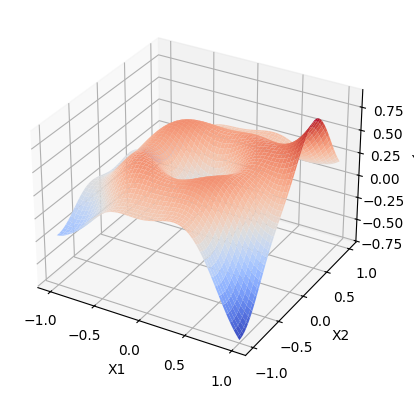

In [157]:
# X_t.shape
# torch.Size([100, 2])

# Y_t.shape
# torch.Size([100, 1])

#plot countourf

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X_fine = interval_torch(100, 2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X_t[:, 0].reshape(10, 10), X_t[:, 1].reshape(10, 10), Y_t.reshape(10, 10), cmap=cm.coolwarm)
# ax.plot_surface(X_t[:, 0].reshape(10, 10), X_t[:, 1].reshape(10, 10), model(X_t).detach().numpy()[:,0].reshape(10, 10), cmap=cm.coolwarm)
ax.plot_surface(X_fine[:, 0].reshape(100, 100), X_fine[:, 1].reshape(100, 100), model(X_fine).detach().numpy()[:,0].reshape(100, 100), cmap=cm.coolwarm)
#botorch
# ax.plot_surface(X_fine[:, 0].reshape(100, 100), X_fine[:, 1].reshape(100, 100), pred_y.reshape(100, 100), cmap=cm.coolwarm)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [158]:
# import matplotlib.pyplot as plt

# x_fine = torch.linspace(-3, 10, 1000).unsqueeze(-1).double()
# plt.figure(figsize=(10,10))
# # X_t.shape
# # torch.Size([100, 2])
# plt.plot(X_t, Y_t, 'r.')
# # plt.plot(X_outliers, Y_outliers, 'rx')
# plt.plot(x_fine, model(x_fine).detach().numpy()[:,0],'g--', lw=3, label='GP Model')
# plt.plot(x_fine, pred_y, 'k--', lw=3, label='BoTorch Model')
# plt.plot(x_fine, F(x_fine).detach().numpy(),'b-')
# plt.legend()
# ax = plt.gca()
# ax.set_ylim(-5, 10)

In [159]:
# model parameters
# list(model.parameters())